
## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("CrimeData").getOrCreate()

# File location and type
file_location = "CrimeData.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load("CrimeData.csv")

display(df)

DataFrame[ID: int, Case Number: string, Date: string, Block: string, IUCR: string, Primary Type: string, Description: string, Location Description: string, Arrest: boolean, Domestic: boolean, Beat: int, District: int, Ward: int, Community Area: int, FBI Code: string, X Coordinate: int, Y Coordinate: int, Year: int, Updated On: string, Latitude: double, Longitude: double, Location: string]

In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession if one doesn't already exist
spark = SparkSession.builder.appName("CrimeData").getOrCreate()

# File location and type
file_location = "CrimeData.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load("CrimeData.csv")

display(df)

DataFrame[ID: int, Case Number: string, Date: string, Block: string, IUCR: string, Primary Type: string, Description: string, Location Description: string, Arrest: boolean, Domestic: boolean, Beat: int, District: int, Ward: int, Community Area: int, FBI Code: string, X Coordinate: int, Y Coordinate: int, Year: int, Updated On: string, Latitude: double, Longitude: double, Location: string]

In [ ]:
# Create a view or table

temp_table_name = "CrimeData_1_csv"

df.createOrReplaceTempView(temp_table_name)

In [ ]:
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

permanent_table_name = "CrimeData_1_csv"

# df.write.format("parquet").saveAsTable(permanent_table_name)

Step 1: Check for Missing Values


In [ ]:
# Create df_cleaned by dropping rows where key columns are null
df_cleaned = df.dropna(subset=[
    "Primary Type", "Location Description",
    "X Coordinate", "Y Coordinate",
    "Latitude", "Longitude"
])


In [ ]:
from pyspark.sql.functions import col, sum, when

# Count missing (null) values in each column of df_cleaned
df_cleaned.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_cleaned.columns
]).show()


+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|  Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|                   0|     0|       0|   0|       0|293744|        292574|       0|           0|           0|   0|         0|       0|        0|       0|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

Drop Duplicate Records

In [ ]:
# Count total rows and distinct rows
total_rows = df_cleaned.count()
distinct_rows = df_cleaned.distinct().count()

print(f"Total Rows: {total_rows}")
print(f"Distinct Rows: {distinct_rows}")
print(f"Number of Duplicate Rows: {total_rows - distinct_rows}")



Total Rows: 412297
Distinct Rows: 412297
Number of Duplicate Rows: 0


 Step 4: Handle Outliers in Numerical Columns

Step 4: Convert Categorical Variables to Numeric

In [ ]:
from pyspark.sql.functions import col

# List of numerical columns to handle outliers
numerical_cols = [
    "Beat", "District", "Ward", "Community Area",
    "X Coordinate", "Y Coordinate", "Latitude", "Longitude"
]


# Start with the cleaned DataFrame
df_no_outliers = df_cleaned

# Remove outliers based on IQR method for each column
for col_name in numerical_cols:
    quantiles = df_no_outliers.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_no_outliers = df_no_outliers.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

# Optional: Check how many rows remain after outlier removal
print("Original Row Count:", df_cleaned.count())
print("After Outlier Removal:", df_no_outliers.count())


Original Row Count: 412297
After Outlier Removal: 117580


In [ ]:
# Assuming df_no_outliers is the final DataFrame after outlier removal
df_final = df_no_outliers

# Now you can print the schema
df_final.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
df_final.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



**EDA**

**1. Summary Statistics for Numerical Features**

In [ ]:
from pyspark.sql import functions as F

results = []
for column in numerical_cols:
    stats = df_final.agg(
        F.count(F.col(column)).alias('count'),
        F.mean(F.col(column)).alias('mean'),
        F.stddev(F.col(column)).alias('stddev'),
        F.min(F.col(column)).alias('min'),
        F.max(F.col(column)).alias('max'),
        F.percentile_approx(F.col(column), 0.5).alias('median'),
        F.skewness(F.col(column)).alias('skewness'),
        F.kurtosis(F.col(column)).alias('kurtosis')
    ).collect()[0]

    results.append({
        'column': column,
        'count': stats['count'],
        'mean': stats['mean'],
        'stddev': stats['stddev'],
        'min': stats['min'],
        'max': stats['max'],
        'median': stats['median'],
        'skewness': stats['skewness'],
        'kurtosis': stats['kurtosis']
    })

# Convert to Pandas DataFrame for better display
import pandas as pd
pd.DataFrame(results)

,column,count,mean,stddev,min,max,median,skewness,kurtosis
0,Beat,117580,1.151198e+03,707.272637,1.110000e+02,2.535000e+03,1.024000e+03,0.410552,-0.919951
1,District,117580,1.126209e+01,7.061776,1.000000e+00,3.100000e+01,1.000000e+01,0.414778,-0.912144
2,Ward,117580,2.279530e+01,13.728756,1.000000e+00,5.000000e+01,2.200000e+01,0.217445,-1.020529
3,Community Area,117580,3.654455e+01,21.422345,1.000000e+00,7.700000e+01,3.200000e+01,0.207863,-1.048096
4,X Coordinate,117580,1.165471e+06,15601.610149,1.123075e+06,1.205119e+06,1.166922e+06,-0.122826,-0.456172
5,Y Coordinate,117580,1.886353e+06,31534.505101,1.813897e+06,1.951503e+06,1.891851e+06,-0.064868,-0.932186
6,Latitude,117580,4.184373e+01,0.086711,4.164459e+01,4.202255e+01,4.185880e+01,-0.066142,-0.934577
7,Longitude,117580,-8.766829e+01,0.056779,-8.782268e+01,-8.752453e+01,-8.766309e+01,-0.134445,-0.457126


**2. Categorical Feature Analysis**

In [ ]:
# Analyze categorical features (now indexed)

# Define or retrieve the list of categorical columns
categorical_cols = ['Primary Type', 'Location Description', 'Arrest', 'Domestic'] # Example columns

# Create indexed columns using StringIndexer if they don't exist
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

for col in categorical_cols:
    # Check if the indexed column already exists
    if col + "_index" not in df_final.columns:
        # Cast boolean columns to integers before applying StringIndexer
        if df_final.schema[col].dataType.typeName() == 'boolean':
            df_final = df_final.withColumn(col, df_final[col].cast(IntegerType()))
        indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
        df_final = indexer.fit(df_final).transform(df_final)

# Now you can group by the indexed columns
for col in [c + "_index" for c in categorical_cols]:
    df_final.groupBy(col).count().orderBy('count', ascending=False).show(truncate=False)

+------------------+-----+
|Primary Type_index|count|
+------------------+-----+
|0.0               |24260|
|1.0               |17753|
|2.0               |12746|
|3.0               |11004|
|4.0               |10069|
|5.0               |8973 |
|6.0               |6732 |
|7.0               |6414 |
|8.0               |5245 |
|9.0               |3428 |
|10.0              |2841 |
|11.0              |2419 |
|12.0              |1834 |
|13.0              |914  |
|14.0              |908  |
|15.0              |659  |
|16.0              |296  |
|17.0              |241  |
|18.0              |228  |
|19.0              |227  |
+------------------+-----+
only showing top 20 rows

+--------------------------+-----+
|Location Description_index|count|
+--------------------------+-----+
|0.0                       |36457|
|1.0                       |21108|
|2.0                       |13074|
|3.0                       |5441 |
|4.0                       |3384 |
|5.0                       |3283 |
|6.0       

a) Basic Count Plots for Categorical Variables
Bar Charts (Top Crime Types, Locations, etc.)

In [ ]:
# Top 10 Primary Crime Types
display(
    df_final.groupBy("Primary Type") # Change "primary_type" to "Primary Type"
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

DataFrame[Primary Type: string, count: bigint]

b) Temporal Trends (Line/Bar Charts)
Crimes by Hour of Day

In [ ]:
display(df_final.groupBy("arrest").count())

DataFrame[arrest: int, count: bigint]

c) Geospatial Heatmaps
- Crime Density by Latitude/Longitude

In [ ]:
# Sample 10% of data for faster rendering
display(
    df_final.sample(0.1)
    .select("latitude", "longitude", "Primary Type") # Change "primary_type" to "Primary Type"
)

DataFrame[latitude: double, longitude: double, Primary Type: string]

d) Comparative Analysis
- Arrest Rate by Crime Type (Stacked Bar)

In [ ]:
display(
    df_final.groupBy("Primary Type", "arrest")  # Change "primary_type" to "Primary Type"
    .count()
    .orderBy("Primary Type")  # Change "primary_type" to "Primary Type"
)

DataFrame[Primary Type: string, arrest: int, count: bigint]

e) Domestic Crimes by Location

In [ ]:
display(
    df_final.filter(F.col("domestic") == True)
    .groupBy("Location Description")  # Change "location_description" to "Location Description"
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

DataFrame[Location Description: string, count: bigint]

f) Correlation Heatmap (For Numeric Features)

In [ ]:
numeric_cols = ["X Coordinate", "Y Coordinate", "Ward", "Primary Type_index"]  # Use actual column names from df_final
corr_df = df_final.select(numeric_cols).toPandas().corr()

display(corr_df.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1))

,X Coordinate,Y Coordinate,Ward,Primary Type_index
X Coordinate,1.000000,-0.527716,-0.491654,-0.032125
Y Coordinate,-0.527716,1.000000,0.730956,-0.033840
Ward,-0.491654,0.730956,1.000000,-0.028574
Primary Type_index,-0.032125,-0.033840,-0.028574,1.000000


**3. Code to Extract and Visualize Key Insights from Crime Dataset**

<ipython-input-51-5b052f6909a0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='Primary Type', data=crime_type_dist, palette='viridis') # Corrected column name
<ipython-input-51-5b052f6909a0>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='arrest_rate', y='Primary Type', data=arrest_rates, palette='rocket') # Corrected column name
<ipython-input-51-5b052f6909a0>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ward', data=ward_dist, palette='mako')


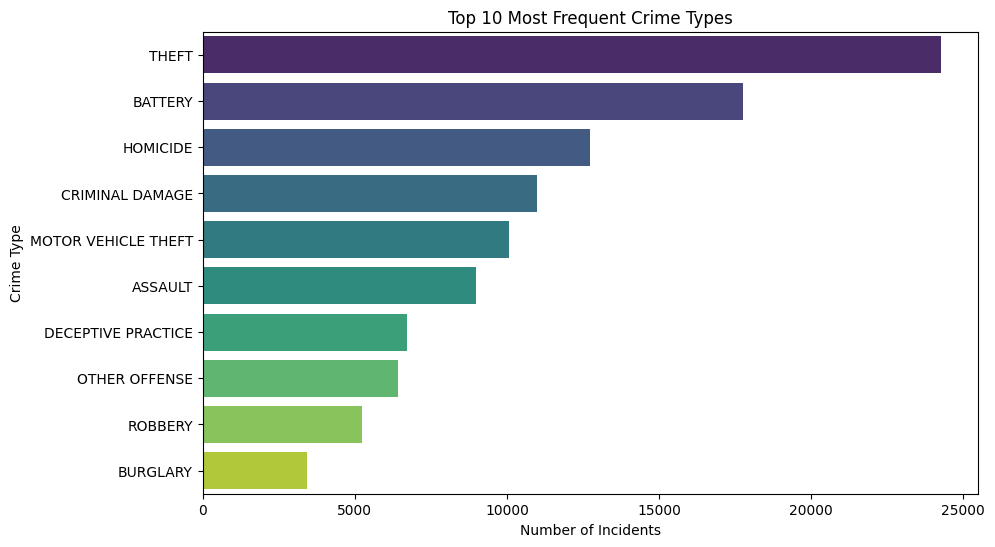

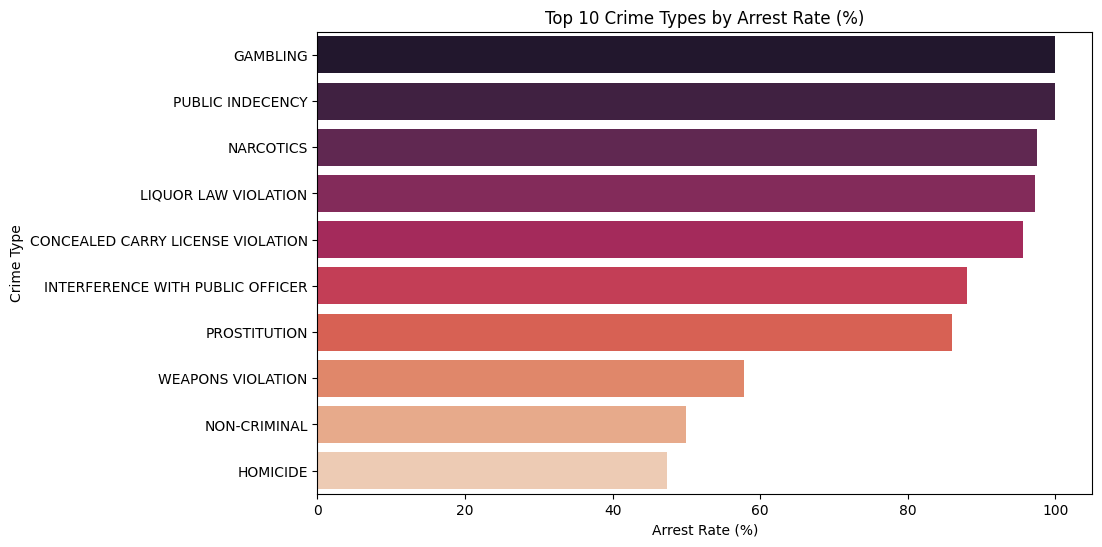

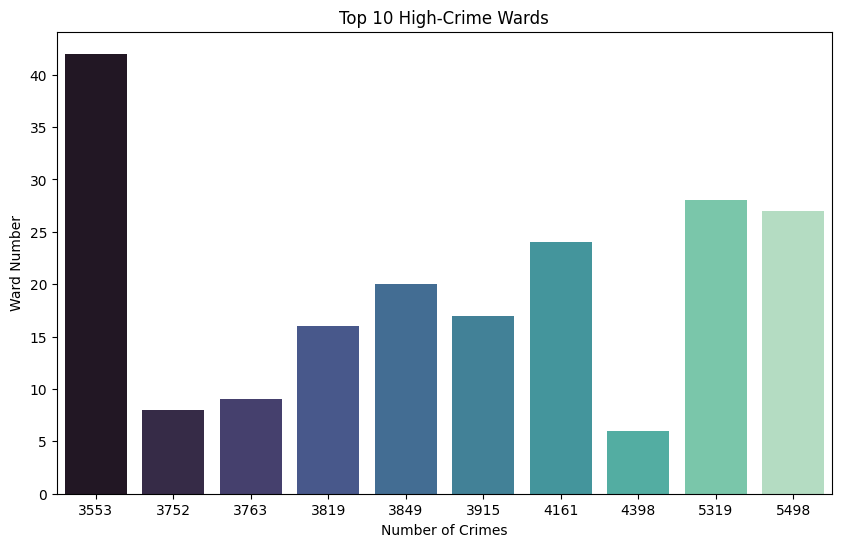

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cache the dataframe for faster processing
df_final.cache()

## Insight 1: Crime Type Distribution (Top 10)
crime_type_dist = df_final.groupBy("Primary Type") \
                         .count() \
                         .orderBy(F.desc("count")) \
                         .limit(10) \
                         .toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x='count', y='Primary Type', data=crime_type_dist, palette='viridis') # Corrected column name
plt.title('Top 10 Most Frequent Crime Types')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')
display()

## Insight 2: Arrest Rates by Crime Type
arrest_rates = df_final.groupBy("Primary Type") \
                      .agg((F.sum(F.col("arrest").cast("int"))/F.count("*")*100).alias("arrest_rate")) \
                      .orderBy(F.desc("arrest_rate")) \
                      .limit(10) \
                      .toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x='arrest_rate', y='Primary Type', data=arrest_rates, palette='rocket') # Corrected column name
plt.title('Top 10 Crime Types by Arrest Rate (%)')
plt.xlabel('Arrest Rate (%)')
plt.ylabel('Crime Type')
display()


## Insight 4: Geospatial Hotspots - Top Wards
ward_dist = df_final.groupBy("ward") \
                   .count() \
                   .orderBy(F.desc("count")) \
                   .limit(10) \
                   .toPandas()

plt.figure(figsize=(10,6))
sns.barplot(x='count', y='ward', data=ward_dist, palette='mako')
plt.title('Top 10 High-Crime Wards')
plt.xlabel('Number of Crimes')
plt.ylabel('Ward Number')
display()



✅ GBT Accuracy: 0.7618


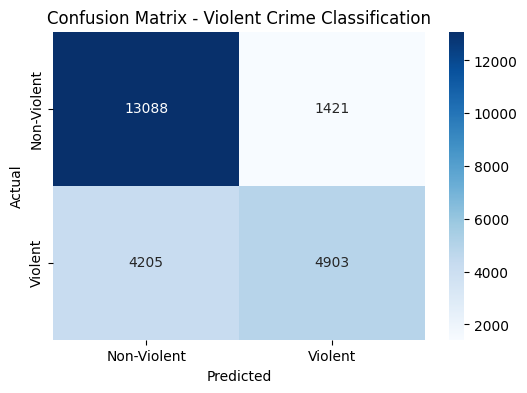

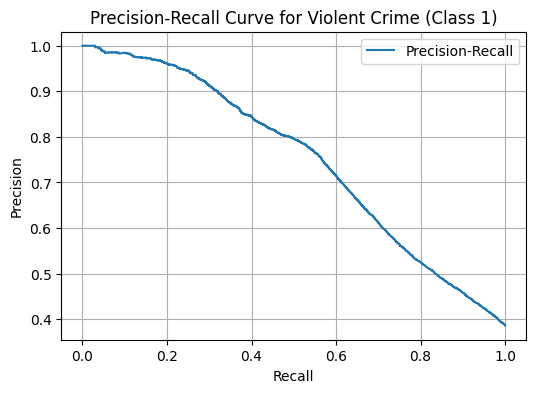

<ipython-input-87-2e4cfa540a3d>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Non-Violent", "Violent"], y=[f1_class_0, f1_class_1], palette="viridis")


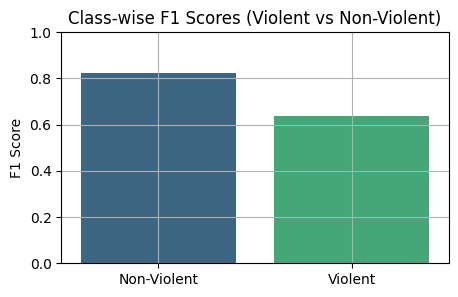

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, f1_score
import pandas as pd

# STEP 1: Map Primary Type to risk_label
violent_crimes = ['HOMICIDE', 'ROBBERY', 'ASSAULT', 'BATTERY', 'CRIMINAL SEXUAL ASSAULT']
df_final = df_final.withColumn("risk_label", when(col("Primary Type").isin(violent_crimes), 1).otherwise(0))

# STEP 2: Extract time features
df_final = df_final.withColumn("hour", col("date").substr(12, 2).cast("int"))
df_final = df_final.withColumn("weekday", col("date").cast("date").cast("timestamp").cast("long") % 7)
df_final = df_final.withColumn("month", col("date").substr(6, 2).cast("int"))

# STEP 3: Features
feature_cols = [
    'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude',
    'Ward', 'District', 'Community Area',
    'Arrest_index', 'Domestic_index', 'Year', 'hour', 'weekday', 'month'
]
df_final = df_final.fillna(0, subset=feature_cols)

# STEP 4: ML pipeline
indexer = StringIndexer(inputCol="risk_label", outputCol="label_gbt")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=100, maxDepth=5)
pipeline = Pipeline(stages=[indexer, assembler, gbt])

# STEP 5: Train/test split
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# STEP 6: Train model
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# STEP 7: Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label_gbt", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"✅ GBT Accuracy: {accuracy:.4f}")

# STEP 8: Confusion matrix heatmap
conf_df = predictions.groupBy("label", "prediction").count().toPandas().pivot(index="label", columns="prediction", values="count").fillna(0)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt='g', cmap='Blues', xticklabels=["Non-Violent", "Violent"], yticklabels=["Non-Violent", "Violent"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Violent Crime Classification")
plt.show()

# STEP 9: Precision-Recall curve (best for minority class)
pred_probs = predictions.withColumn("prob", vector_to_array("rawPrediction")[1])
pr_df = pred_probs.select("label", "prob").toPandas()
prec, rec, _ = precision_recall_curve(pr_df["label"], pr_df["prob"])

plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Violent Crime (Class 1)")
plt.grid(True)
plt.legend()
plt.show()

# STEP 10: Class-wise F1 Score
y_true = pr_df["label"]
y_pred = predictions.select("prediction").toPandas()["prediction"]
f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

plt.figure(figsize=(5, 3))
sns.barplot(x=["Non-Violent", "Violent"], y=[f1_class_0, f1_class_1], palette="viridis")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Scores (Violent vs Non-Violent)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [78]:
!pip install pyspark --quiet

In [80]:
!pip install xgboost

In [81]:
# Install PySpark and XGBoost if not already installed (only in Colab or fresh kernel)
!pip install pyspark xgboost --quiet

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, monotonically_increasing_id, expr
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier

# Initialize Spark
spark = SparkSession.builder.appName("LR_RF_XGB_Ensemble").getOrCreate()

# Assuming df_final is your DataFrame and already has necessary columns
# If not, load your data here

# Define feature columns
feature_cols = [
    'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude',
    'Ward', 'District', 'Community Area',
    'Arrest_index', 'Domestic_index', 'Year', 'hour', 'weekday', 'month'
]

# Compute class weights
total = df_final.count()
pos = df_final.filter("risk_label = 1").count()
neg = total - pos
w_pos = total / (2 * pos)
w_neg = total / (2 * neg)

# Apply class weights
df_final = df_final.withColumn("class_weight", when(col("risk_label") == 1, w_pos).otherwise(w_neg))

# String index label
indexer = StringIndexer(inputCol="risk_label", outputCol="label")
df_final = indexer.fit(df_final).transform(df_final)

# Assemble + scale features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="unscaled_features")
df_assembled = assembler.transform(df_final)
scaler = MinMaxScaler(inputCol="unscaled_features", outputCol="features")
df_scaled = scaler.fit(df_assembled).transform(df_assembled)

# Train/test split
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)

# Define models
lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="class_weight", maxIter=50)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
xgb = SparkXGBClassifier(
    features_col="features",
    label_col="label",
    weight_col="class_weight",
    num_workers=2  # Set this to your number of available CPU cores
)

# Train models
model_lr = lr.fit(train_data)
model_rf = rf.fit(train_data)
model_xgb = xgb.fit(train_data)

# Predictions
pred_lr = model_lr.transform(test_data).select("label", "prediction").withColumnRenamed("prediction", "pred_lr")
pred_rf = model_rf.transform(test_data).select("prediction").withColumnRenamed("prediction", "pred_rf")
pred_xgb = model_xgb.transform(test_data).select("prediction").withColumnRenamed("prediction", "pred_xgb")

# Assign unique ID to join
pred_lr = pred_lr.withColumn("id", monotonically_increasing_id())
pred_rf = pred_rf.withColumn("id", monotonically_increasing_id())
pred_xgb = pred_xgb.withColumn("id", monotonically_increasing_id())

# Combine predictions
ensemble_df = pred_lr.join(pred_rf, "id").join(pred_xgb, "id")

# Majority voting: at least 2 out of 3 = 1 (violent), else 0
ensemble_df = ensemble_df.withColumn("final_pred", expr("double((pred_lr + pred_rf + pred_xgb) >= 2)"))

# Cast for evaluator
ensemble_df = ensemble_df.withColumn("label", col("label").cast(DoubleType()))
ensemble_df = ensemble_df.withColumn("final_pred", col("final_pred").cast(DoubleType()))

# Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="final_pred", metricName="accuracy")
accuracy = evaluator.evaluate(ensemble_df)
print(f"✅ Final Ensemble Accuracy: {accuracy:.4f}")

# Show confusion matrix
ensemble_df.groupBy("label", "final_pred").count().show()

INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


✅ Final Ensemble Accuracy: 0.7579
+-----+----------+-----+
|label|final_pred|count|
+-----+----------+-----+
|  1.0|       1.0| 5052|
|  0.0|       1.0| 1661|
|  1.0|       0.0| 4056|
|  0.0|       0.0|12848|
+-----+----------+-----+

